In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (confusion_matrix, f1_score, recall_score, precision_score, 
                            accuracy_score, roc_curve, auc, roc_auc_score, 
                            log_loss, brier_score_loss, classification_report,
                            precision_recall_fscore_support)
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import shap



In [15]:
df = pd.read_csv('shots_2007-2023.csv')
print(f"Dataset Shape: {df.shape}")
print(df.head())

print(f"\nTarget variable 'goal' distribution:\n{df['goal'].value_counts()}")
print(f"Goal rate: {df['goal'].mean():.4f}")


Dataset Shape: (1840218, 124)
   shotID homeTeamCode awayTeamCode  season  isPlayoffGame  game_id  \
0       0          TBL          NSH    2023              0    20001   
1       1          TBL          NSH    2023              0    20001   
2       2          TBL          NSH    2023              0    20001   
3       3          TBL          NSH    2023              0    20001   
4       4          TBL          NSH    2023              0    20001   

   homeTeamWon  id  time  timeUntilNextEvent  ...    xFroze  xRebound  \
0            1  10    61                 9.0  ...  0.249174  0.035816   
1            1  11    70                26.0  ...  0.107945  0.051284   
2            1  13   107                 2.0  ...  0.236193  0.030269   
3            1  19   177                35.0  ...  0.198635  0.033686   
4            1  21   231                29.0  ...  0.188582  0.027146   

  xPlayContinuedInZone xPlayContinuedOutsideZone xPlayStopped  xShotWasOnGoal  \
0             0.379310 

             shotID        season  isPlayoffGame       game_id   homeTeamWon  \
count  1.840218e+06  1.840218e+06   1.840218e+06  1.840218e+06  1.840218e+06   
mean   9.201085e+05  2.015146e+03   7.252782e-02  2.130252e+04  5.417787e-01   
std    5.312253e+05  4.960793e+00   2.593599e-01  2.513023e+03  4.982516e-01   
min    0.000000e+00  2.007000e+03   0.000000e+00  2.000100e+04  0.000000e+00   
25%    4.600542e+05  2.011000e+03   0.000000e+00  2.032200e+04  0.000000e+00   
50%    9.201085e+05  2.015000e+03   0.000000e+00  2.064400e+04  1.000000e+00   
75%    1.380163e+06  2.019000e+03   0.000000e+00  2.098600e+04  1.000000e+00   
max    1.840217e+06  2.023000e+03   1.000000e+00  3.041700e+04  1.000000e+00   

                 id          time  timeUntilNextEvent  timeSinceLastEvent  \
count  1.840218e+06  1.840218e+06        1.840218e+06        1.840218e+06   
mean   1.607135e+02  1.835555e+03        1.145011e+01        1.570407e+01   
std    9.231472e+01  1.058338e+03        1.49593

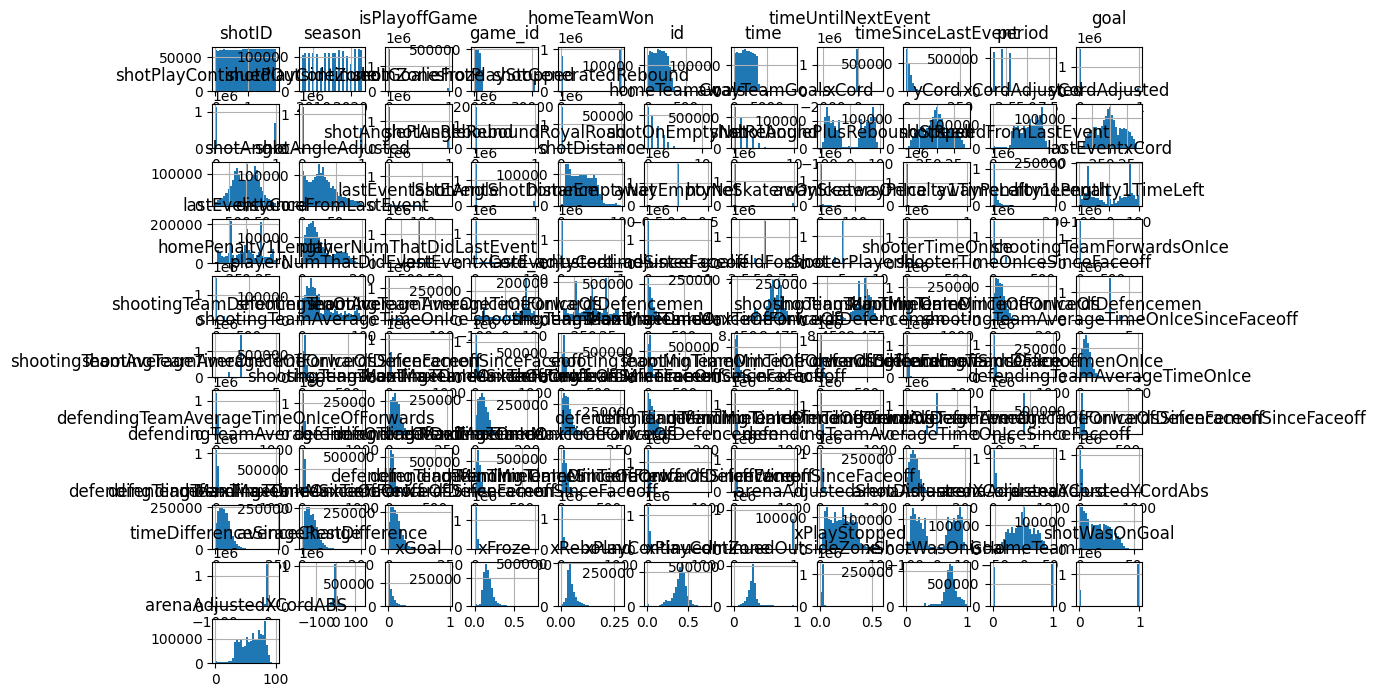

In [16]:
print(df.describe())
print(f"\nData Types:\n{df.dtypes}")

missing_data = df.isnull().sum()
print(f"\nMissing values: {missing_data.sum()}")
if missing_data.sum() > 0:
    df = df.dropna()

print(f"Duplicates: {df.duplicated().sum()}")
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()

numeric_cols = df.select_dtypes(include="number").columns
df[numeric_cols].hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

In [17]:
xg_features = [col for col in df.columns if col.startswith('x') and col != 'xCord' and col != 'xCordAdjusted']
df = df.drop(columns=xg_features)

# Exclude outcome-related features that leak information about the shot result
# 'event' encodes the outcome (GOAL, MISS, SHOT) - this is the target!
# 'goal' is the target variable itself - DO NOT drop it!
leakage_features = ['shotWasOnGoal', 'homeTeamWon', 'event']
leakage_features = [col for col in leakage_features if col in df.columns]
if leakage_features:
    df = df.drop(columns=leakage_features)
    print(f"Excluded outcome/leakage features: {leakage_features}")

if 'lastEventCategory' in df.columns:
    if df['lastEventCategory'].dtype == 'object':
        unique_events = df['lastEventCategory'].unique()
        if 'GOAL' in str(unique_events):
            df = df.drop(columns=['lastEventCategory'])
            print(f"Excluded 'lastEventCategory' (contains GOAL information)")

if 'goal' not in df.columns:
    print(f"Error: 'goal' column not found in dataframe!")
    print(f"Available columns: {df.columns.tolist()}")
    # Try to find potential target columns
    potential_targets = [col for col in df.columns if 'goal' in col.lower() or 'target' in col.lower()]
    if potential_targets:
        print(f"Potential target columns found: {potential_targets}")
    raise KeyError("'goal' column is missing. Please check if it was accidentally dropped or renamed.")
else:
    print(f"Target distribution:\n{df['goal'].value_counts()}")
    print(f"Goal rate: {df['goal'].mean():.4f}")

print(f"\nExcluded {len(xg_features)} xG-related features to prevent data leakage")

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

Excluded outcome/leakage features: ['shotWasOnGoal', 'homeTeamWon', 'event']
Excluded 'lastEventCategory' (contains GOAL information)
Target distribution:
goal
0    1706023
1     116885
Name: count, dtype: int64
Goal rate: 0.0641

Excluded 7 xG-related features to prevent data leakage


In [18]:
categorical_cols_to_encode = ['shotType', 'shooterLeftRight']
if 'lastEventCategory' in df.columns:
    categorical_cols_to_encode.append('lastEventCategory')

ohe_cols = [col for col in categorical_cols_to_encode if col in df.columns]
if ohe_cols:
    df = pd.get_dummies(df, columns=ohe_cols, drop_first=False)
    print(f"One-hot encoded columns: {ohe_cols}")
    
    encoded_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in ohe_cols)]
    for col in encoded_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(int)

drop_cols = ['shotID', 'homeTeamCode', 'awayTeamCode', 'game_id', 'id', 'teamCode', 
             'shooterName', 'goalieNameForShot', 'playerPositionThatDidEvent']
drop_cols = [col for col in drop_cols if col in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
    print(f"Dropped columns: {drop_cols}")

One-hot encoded columns: ['shotType', 'shooterLeftRight']
Dropped columns: ['shotID', 'homeTeamCode', 'awayTeamCode', 'game_id', 'id', 'teamCode', 'shooterName', 'goalieNameForShot', 'playerPositionThatDidEvent']


In [19]:

# 'timeUntilNextEvent' may leak information about what happened after the shot

# CRITICAL: These features describe what happened AFTER the shot - they leak the outcome!
# When a goal is scored, play stops, so these are all 0 for goals
# This creates perfect separability and 100% accuracy
temporal_leakage_features = [
    'shotPlayStopped',           # Play stopped after shot (includes goals!)
    'shotGeneratedRebound',      # Rebound generated (can't happen if goal)
    'shotPlayContinuedInZone',   # Play continued in zone (can't happen if goal)
    'shotPlayContinuedOutsideZone', # Play continued outside zone (can't happen if goal)
    'shotGoalieFroze'            # Goalie froze puck within 1 second AFTER shot - if frozen, wasn't a goal!
]

drop_cols_before_split = ['game_id', 'time', 'id', 'timeUntilNextEvent'] + temporal_leakage_features
drop_cols_before_split = [col for col in drop_cols_before_split if col in df.columns]
if drop_cols_before_split:
    df = df.drop(columns=drop_cols_before_split)
    print(f"Dropped columns before split: {drop_cols_before_split}")
    if any(col in temporal_leakage_features for col in drop_cols_before_split):
        print(f"⚠️  CRITICAL: Dropped temporal leakage features that describe post-shot outcomes!")

y = df['goal']
X = df.drop(columns=['goal'])

print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Classes: {y.unique()}")

Dropped columns before split: ['time', 'timeUntilNextEvent', 'shotPlayStopped', 'shotGeneratedRebound', 'shotPlayContinuedInZone', 'shotPlayContinuedOutsideZone', 'shotGoalieFroze']
⚠️  CRITICAL: Dropped temporal leakage features that describe post-shot outcomes!
Feature Matrix Shape: (1822908, 103)
Target Classes: [0 1]


In [20]:
# Feature Engineering: Create interaction features to capture non-linear relationships
# These features help the model learn complex patterns that improve goal prediction

print("Creating interaction features...")
original_feature_count = X.shape[1]
new_features = []

# 1. Shot angle × distance interactions (highest priority)
if 'shotAngleAdjusted' in X.columns and 'shotDistance' in X.columns:
    X['angle_distance_interaction'] = X['shotAngleAdjusted'] * X['shotDistance']
    new_features.append('angle_distance_interaction')
    print("  ✓ Created: angle_distance_interaction")

if 'shotAngleAdjusted' in X.columns and 'arenaAdjustedShotDistance' in X.columns:
    X['angle_arenaDistance_interaction'] = X['shotAngleAdjusted'] * X['arenaAdjustedShotDistance']
    new_features.append('angle_arenaDistance_interaction')
    print("  ✓ Created: angle_arenaDistance_interaction")

# 2. Shot type × location interactions (check for one-hot encoded shotType columns)
shotType_cols = [col for col in X.columns if col.startswith('shotType_')]
if shotType_cols and 'shotDistance' in X.columns:
    for shotType_col in shotType_cols:
        feature_name = f'{shotType_col}_distance'
        X[feature_name] = X[shotType_col] * X['shotDistance']
        new_features.append(feature_name)
    print(f"  ✓ Created: {len(shotType_cols)} shotType × distance interactions")

if shotType_cols and 'shotAngleAdjusted' in X.columns:
    for shotType_col in shotType_cols:
        feature_name = f'{shotType_col}_angle'
        X[feature_name] = X[shotType_col] * X['shotAngleAdjusted']
        new_features.append(feature_name)
    print(f"  ✓ Created: {len(shotType_cols)} shotType × angle interactions")

# 3. Rush × distance/angle interactions
if 'shotRush' in X.columns:
    if 'shotDistance' in X.columns:
        X['rush_distance'] = X['shotRush'] * X['shotDistance']
        new_features.append('rush_distance')
        print("  ✓ Created: rush_distance")
    if 'shotAngleAdjusted' in X.columns:
        X['rush_angle'] = X['shotRush'] * X['shotAngleAdjusted']
        new_features.append('rush_angle')
        print("  ✓ Created: rush_angle")

# 4. Rebound × distance/angle interactions
if 'shotRebound' in X.columns:
    if 'shotDistance' in X.columns:
        X['rebound_distance'] = X['shotRebound'] * X['shotDistance']
        new_features.append('rebound_distance')
        print("  ✓ Created: rebound_distance")
    if 'shotAngleAdjusted' in X.columns:
        X['rebound_angle'] = X['shotRebound'] * X['shotAngleAdjusted']
        new_features.append('rebound_angle')
        print("  ✓ Created: rebound_angle")

# 5. Off-wing advantage interactions
if 'offWing' in X.columns:
    if 'shotDistance' in X.columns:
        X['offWing_distance'] = X['offWing'] * X['shotDistance']
        new_features.append('offWing_distance')
        print("  ✓ Created: offWing_distance")
    if 'shotAngleAdjusted' in X.columns:
        X['offWing_angle'] = X['offWing'] * X['shotAngleAdjusted']
        new_features.append('offWing_angle')
        print("  ✓ Created: offWing_angle")

# 6. Time remaining features (period × time)
if 'period' in X.columns and 'time' in X.columns:
    # Note: 'time' was dropped in Cell 5, so this won't work
    # But we can use timeSinceLastEvent as proxy
    pass

# 7. Skater advantage calculation
if 'homeSkatersOnIce' in X.columns and 'awaySkatersOnIce' in X.columns:
    # For home team shots: advantage = homeSkaters - awaySkaters
    # For away team shots: advantage = awaySkaters - homeSkaters
    # We'll create a general advantage feature (positive = more skaters for shooting team)
    if 'isHomeTeam' in X.columns:
        X['skaterAdvantage'] = np.where(
            X['isHomeTeam'] == 1,
            X['homeSkatersOnIce'] - X['awaySkatersOnIce'],
            X['awaySkatersOnIce'] - X['homeSkatersOnIce']
        )
    else:
        # If we don't know which team, use absolute difference
        X['skaterAdvantage'] = X['homeSkatersOnIce'] - X['awaySkatersOnIce']
    new_features.append('skaterAdvantage')
    print("  ✓ Created: skaterAdvantage")
    
    # Skater advantage × distance interaction
    if 'shotDistance' in X.columns:
        X['skaterAdvantage_distance'] = X['skaterAdvantage'] * X['shotDistance']
        new_features.append('skaterAdvantage_distance')
        print("  ✓ Created: skaterAdvantage_distance")

# 8. Speed × distance interaction
if 'speedFromLastEvent' in X.columns and 'shotDistance' in X.columns:
    X['speed_distance'] = X['speedFromLastEvent'] * X['shotDistance']
    new_features.append('speed_distance')
    print("  ✓ Created: speed_distance")

# 9. Empty net × distance interaction
if 'shotOnEmptyNet' in X.columns and 'shotDistance' in X.columns:
    X['emptyNet_distance'] = X['shotOnEmptyNet'] * X['shotDistance']
    new_features.append('emptyNet_distance')
    print("  ✓ Created: emptyNet_distance")

# 10. Time since faceoff × distance interaction
if 'timeSinceFaceoff' in X.columns and 'shotDistance' in X.columns:
    X['faceoffTime_distance'] = X['timeSinceFaceoff'] * X['shotDistance']
    new_features.append('faceoffTime_distance')
    print("  ✓ Created: faceoffTime_distance")

# 11. Penalty time remaining interactions (power play strength)
if 'homePenalty1TimeLeft' in X.columns and 'awayPenalty1TimeLeft' in X.columns:
    # Power play indicator: positive penalty time = advantage
    if 'isHomeTeam' in X.columns:
        X['powerPlayStrength'] = np.where(
            X['isHomeTeam'] == 1,
            X['awayPenalty1TimeLeft'] - X['homePenalty1TimeLeft'],
            X['homePenalty1TimeLeft'] - X['awayPenalty1TimeLeft']
        )
    else:
        X['powerPlayStrength'] = X['awayPenalty1TimeLeft'] - X['homePenalty1TimeLeft']
    new_features.append('powerPlayStrength')
    print("  ✓ Created: powerPlayStrength")
    
    if 'shotDistance' in X.columns:
        X['powerPlay_distance'] = X['powerPlayStrength'] * X['shotDistance']
        new_features.append('powerPlay_distance')
        print("  ✓ Created: powerPlay_distance")

# 12. Location × distance interactions (if location is numeric or encoded)
location_cols = [col for col in X.columns if col.startswith('location_')]
if location_cols and 'shotDistance' in X.columns:
    for loc_col in location_cols:
        feature_name = f'{loc_col}_distance'
        X[feature_name] = X[loc_col] * X['shotDistance']
        new_features.append(feature_name)
    print(f"  ✓ Created: {len(location_cols)} location × distance interactions")

# Replace any infinite or NaN values with 0
X[new_features] = X[new_features].replace([np.inf, -np.inf], 0).fillna(0)

print(f"\nFeature engineering complete!")
print(f"  Original features: {original_feature_count}")
print(f"  New features created: {len(new_features)}")
print(f"  Total features: {X.shape[1]}")
print(f"\nNew feature list: {new_features[:10]}{'...' if len(new_features) > 10 else ''}")



Creating interaction features...
  ✓ Created: angle_distance_interaction
  ✓ Created: angle_arenaDistance_interaction
  ✓ Created: 7 shotType × distance interactions
  ✓ Created: 7 shotType × angle interactions
  ✓ Created: rush_distance
  ✓ Created: rush_angle
  ✓ Created: rebound_distance
  ✓ Created: rebound_angle
  ✓ Created: offWing_distance
  ✓ Created: offWing_angle
  ✓ Created: skaterAdvantage
  ✓ Created: skaterAdvantage_distance
  ✓ Created: speed_distance
  ✓ Created: emptyNet_distance
  ✓ Created: faceoffTime_distance
  ✓ Created: powerPlayStrength
  ✓ Created: powerPlay_distance

Feature engineering complete!
  Original features: 103
  New features created: 29
  Total features: 132

New feature list: ['angle_distance_interaction', 'angle_arenaDistance_interaction', 'shotType_BACK_distance', 'shotType_DEFL_distance', 'shotType_SLAP_distance', 'shotType_SNAP_distance', 'shotType_TIP_distance', 'shotType_WRAP_distance', 'shotType_WRIST_distance', 'shotType_BACK_angle']...


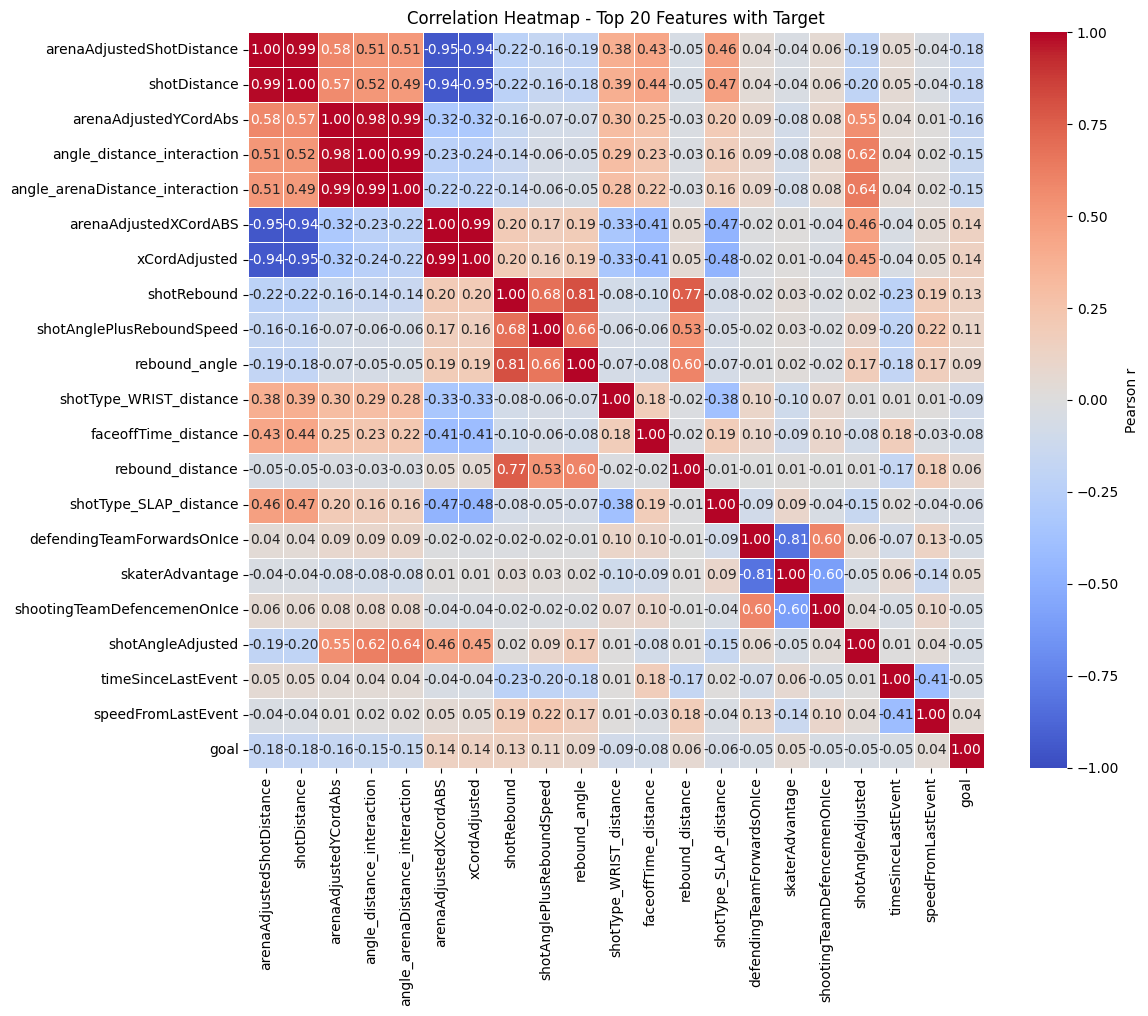

Top features correlated with target:
arenaAdjustedShotDistance          0.177592
shotDistance                       0.175850
arenaAdjustedYCordAbs              0.156926
angle_distance_interaction         0.152136
angle_arenaDistance_interaction    0.151500
arenaAdjustedXCordABS              0.143665
xCordAdjusted                      0.143104
shotRebound                        0.132975
shotAnglePlusReboundSpeed          0.105944
rebound_angle                      0.090135
Name: goal, dtype: float64


In [21]:
temp_df = pd.concat([X, y], axis=1)
numeric_df = temp_df.select_dtypes(include="number")
correlation_matrix = numeric_df.corr(numeric_only=True)

corr_with_target = correlation_matrix['goal'].drop(labels=['goal']).abs().sort_values(ascending=False)
top_features = corr_with_target.head(20).index.tolist()
top_features.append('goal')

top_corr_matrix = correlation_matrix.loc[top_features, top_features]

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            vmin=-1, vmax=1, center=0, square=True, cbar_kws={"label": "Pearson r"},
            linewidths=0.5, linecolor='white')
plt.title("Correlation Heatmap - Top 20 Features with Target")
plt.tight_layout()
plt.show()

print("Top features correlated with target:")
print(corr_with_target.head(10))

In [22]:
# Stratification ensures the proportion of classes (goals vs no-goals) is maintained
# across train/val/test splits. For example, if 10% of shots are goals, then each
# split will have approximately 10% goals. This prevents one split from having
# all goals and another having none, which would bias model evaluation.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

print(f"Training: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")
print(f"\nGoal rate verification (should be similar across splits):")
print(f"Train: {y_train.mean():.4f}, Val: {y_val.mean():.4f}, Test: {y_test.mean():.4f}")
print(f"Overall: {y.mean():.4f}")

Training: 1276035, Validation: 364582, Test: 182291

Goal rate verification (should be similar across splits):
Train: 0.0641, Val: 0.0641, Test: 0.0641
Overall: 0.0641


In [23]:
# CRITICAL: Drop leaky features BEFORE encoding
# 'lastEventTeam' contains "GOAL" as a value - this directly leaks target information!
# 'homeTeamGoals' and 'awayTeamGoals' might be scores AFTER the goal (leakage) - drop to be safe
# These features must be dropped from ALL splits (numeric or categorical)
leaky_features_to_drop = ['lastEventTeam', 'event', 'homeTeamGoals', 'awayTeamGoals']
leaky_features_to_drop = [col for col in leaky_features_to_drop if col in X_train.columns]

if leaky_features_to_drop:
    print(f"⚠️  CRITICAL: Dropping leaky features: {leaky_features_to_drop}")
    X_train = X_train.drop(columns=leaky_features_to_drop)
    X_val = X_val.drop(columns=leaky_features_to_drop)
    X_test = X_test.drop(columns=leaky_features_to_drop)
    print(f"   Features dropped from all splits to prevent data leakage")

# Identify remaining non-numeric columns that need encoding
# Exclude any columns that might encode outcome information
remaining_categorical = X_train.select_dtypes(include=['object']).columns.tolist()

# Remove any columns that might leak outcome information
# 'event' should already be excluded, but double-check
outcome_related = ['event', 'lastEventTeam']
remaining_categorical = [col for col in remaining_categorical if col not in outcome_related]

# Also check if any categorical columns contain goal-related information
if remaining_categorical:
    for col in remaining_categorical.copy():
        if X_train[col].dtype == 'object':
            unique_vals = str(X_train[col].unique()).upper()
            if 'GOAL' in unique_vals:
                print(f"WARNING: Excluding '{col}' - contains GOAL information (data leakage)")
                remaining_categorical.remove(col)

if remaining_categorical:
    print(f"Remaining categorical columns to encode: {remaining_categorical}")

# Store original numeric columns before encoding
train_numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
val_numeric_cols = X_val.select_dtypes(include=[np.number]).columns.tolist()
test_numeric_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()

if remaining_categorical:
    print(f"Encoding remaining categorical columns: {remaining_categorical}")
    
    # Ensure categorical columns are actually object type before encoding
    remaining_categorical = [col for col in remaining_categorical 
                             if col in X_train.columns and X_train[col].dtype == 'object']
    
    if remaining_categorical:
        # Encode training set first to get all possible categories
        X_train_encoded = pd.get_dummies(X_train, columns=remaining_categorical, drop_first=False, dtype=float)
        
        # Get all columns from training set (this defines our feature space)
        all_columns = X_train_encoded.columns.tolist()
        print(f"Training set has {len(all_columns)} features after encoding")
        
        # Encode validation and test sets separately
        X_val_encoded = pd.get_dummies(X_val, columns=remaining_categorical, drop_first=False, dtype=float)
        X_test_encoded = pd.get_dummies(X_test, columns=remaining_categorical, drop_first=False, dtype=float)
    else:
        # No categorical columns to encode
        X_train_encoded = X_train.copy()
        X_val_encoded = X_val.copy()
        X_test_encoded = X_test.copy()
        all_columns = X_train.columns.tolist()
    
    # Create new DataFrames with exact same columns as training (initialized with zeros)
    X_val = pd.DataFrame(0, index=X_val.index, columns=all_columns, dtype=np.float64)
    X_test = pd.DataFrame(0, index=X_test.index, columns=all_columns, dtype=np.float64)
    
    # Copy over numeric columns (these should be the same across all splits)
    for col in train_numeric_cols:
        if col in all_columns:
            if col in X_val_encoded.columns:
                X_val[col] = pd.to_numeric(X_val_encoded[col], errors='coerce').fillna(0).astype(np.float64)
            if col in X_test_encoded.columns:
                X_test[col] = pd.to_numeric(X_test_encoded[col], errors='coerce').fillna(0).astype(np.float64)
    
    # Copy over one-hot encoded columns that exist in both training and val/test
    for col in all_columns:
        if col not in train_numeric_cols:  # This is a one-hot encoded column
            # For validation set
            if col in X_val_encoded.columns:
                # Convert to numeric, handling any string values
                X_val[col] = pd.to_numeric(X_val_encoded[col], errors='coerce').fillna(0).astype(np.float64)
            else:
                X_val[col] = 0.0
            
            # For test set
            if col in X_test_encoded.columns:
                # Convert to numeric, handling any string values
                X_test[col] = pd.to_numeric(X_test_encoded[col], errors='coerce').fillna(0).astype(np.float64)
            else:
                X_test[col] = 0.0
    
    # Use training encoded dataframe and ensure all columns are numeric
    X_train = X_train_encoded[all_columns].copy()
    
    # Convert one-hot encoded columns to numeric if needed
    for col in X_train.columns:
        if col not in train_numeric_cols:
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0).astype(np.float64)
    
    print(f"Final feature count: {X_train.shape[1]}")
    print(f"Validation columns match: {list(X_val.columns) == list(X_train.columns)}")
    print(f"Test columns match: {list(X_test.columns) == list(X_train.columns)}")
else:
    # No categorical columns, just ensure numeric
    X_train = X_train.select_dtypes(include=[np.number])
    X_val = X_val.select_dtypes(include=[np.number])
    X_test = X_test.select_dtypes(include=[np.number])

# Final check: ensure all columns are numeric
non_numeric = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"Warning: Dropping non-numeric columns: {non_numeric}")
    # Try to convert to numeric first
    for col in non_numeric:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
    # Drop any remaining non-numeric columns
    X_train = X_train.select_dtypes(include=[np.number])

# Get final column list from training (this is our master list)
final_columns = X_train.columns.tolist()

# Ensure val and test have exactly the same columns as training
X_val = X_val.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Add missing columns to val/test (fill with 0)
for col in final_columns:
    if col not in X_val.columns:
        X_val[col] = 0
    if col not in X_test.columns:
        X_test[col] = 0

# Remove extra columns from val/test and reorder to match training
X_val = X_val[final_columns]
X_test = X_test[final_columns]

# Verify column alignment
print(f"\nColumn alignment check:")
print(f"Train columns: {len(X_train.columns)}, Val columns: {len(X_val.columns)}, Test columns: {len(X_test.columns)}")
print(f"Train-Val match: {list(X_train.columns) == list(X_val.columns)}")
print(f"Train-Test match: {list(X_train.columns) == list(X_test.columns)}")

if list(X_train.columns) != list(X_val.columns):
    missing_in_val = set(X_train.columns) - set(X_val.columns)
    extra_in_val = set(X_val.columns) - set(X_train.columns)
    print(f"Missing in Val: {missing_in_val}")
    print(f"Extra in Val: {extra_in_val}")

if list(X_train.columns) != list(X_test.columns):
    missing_in_test = set(X_train.columns) - set(X_test.columns)
    extra_in_test = set(X_test.columns) - set(X_train.columns)
    print(f"Missing in Test: {missing_in_test}")
    print(f"Extra in Test: {extra_in_test}")

assert list(X_train.columns) == list(X_val.columns), f"Train and Val columns don't match! Train: {len(X_train.columns)}, Val: {len(X_val.columns)}"
assert list(X_train.columns) == list(X_test.columns), f"Train and Test columns don't match! Train: {len(X_train.columns)}, Test: {len(X_test.columns)}"

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

⚠️  CRITICAL: Dropping leaky features: ['lastEventTeam', 'homeTeamGoals', 'awayTeamGoals']
   Features dropped from all splits to prevent data leakage
Remaining categorical columns to encode: ['team', 'location']
Encoding remaining categorical columns: ['team', 'location']
Training set has 132 features after encoding
Final feature count: 132
Validation columns match: True
Test columns match: True

Column alignment check:
Train columns: 132, Val columns: 132, Test columns: 132
Train-Val match: True
Train-Test match: True


In [24]:

# Goal rate is ~6.41%, so we weight goals ~15.6x more than non-goals
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")
print(f"  Non-goals (class 0): {class_weight_dict[0]:.4f}")
print(f"  Goals (class 1): {class_weight_dict[1]:.4f}")
print(f"  Ratio: {class_weight_dict[1]/class_weight_dict[0]:.2f}x more weight on goals\n")

models = {}
training_times = {}

start_time = time.time()
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
training_times['Logistic Regression'] = (time.time() - start_time) * 1000
models['Logistic Regression'] = lr_model

start_time = time.time()

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train_scaled, y_train)
training_times['XGBoost'] = (time.time() - start_time) * 1000
models['XGBoost'] = xgb_model

print("Training times (ms):")
for name, t_time in training_times.items():
    print(f"{name}: {t_time:.2f}")

Class weights: {0: np.float64(0.53425636568259), 1: np.float64(7.797913687529792)}
  Non-goals (class 0): 0.5343
  Goals (class 1): 7.7979
  Ratio: 14.60x more weight on goals

Training times (ms):
Logistic Regression: 26830.38
XGBoost: 10890.21


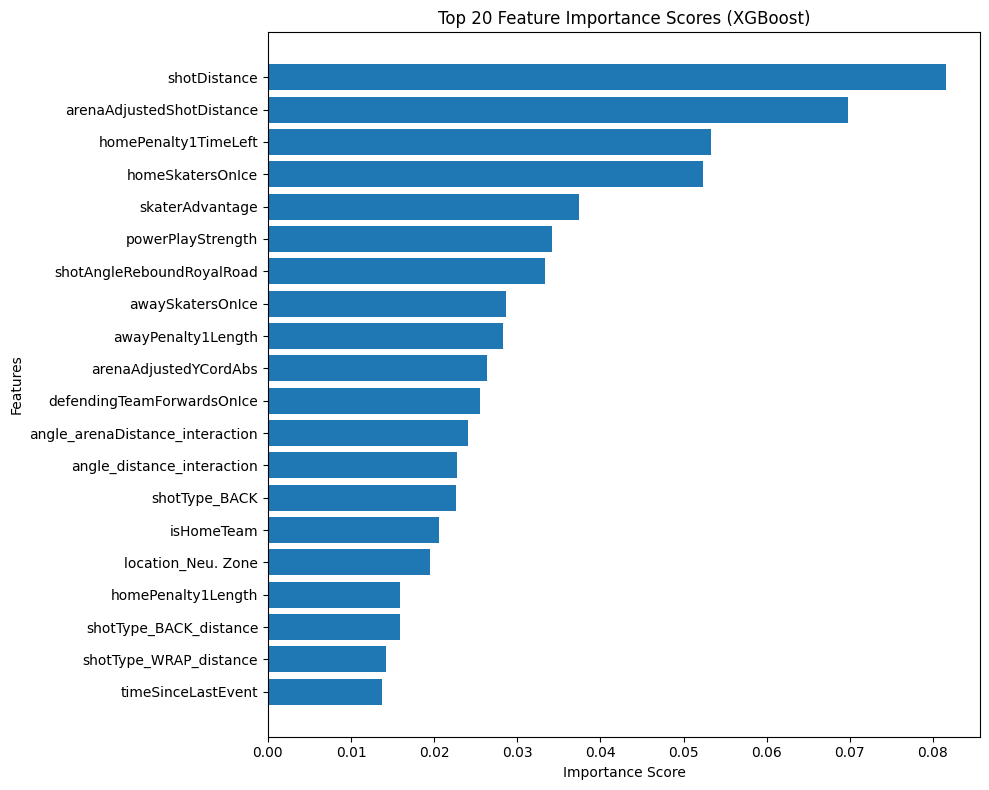


Features for 90% cumulative importance: 70
                       Feature Importance Cumulative_Importance
12                shotDistance    0.08158               0.08158
81   arenaAdjustedShotDistance   0.069796              0.151376
29        homePenalty1TimeLeft   0.053301              0.204677
25            homeSkatersOnIce   0.052289              0.256967
120            skaterAdvantage   0.037474              0.294441
125          powerPlayStrength   0.034179               0.32862
11   shotAngleReboundRoyalRoad   0.033298              0.361918
26            awaySkatersOnIce   0.028617              0.390535
28          awayPenalty1Length   0.028326              0.418861
84       arenaAdjustedYCordAbs   0.026351              0.445213


In [25]:
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 20 Feature Importance Scores (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()
selected_features = importance_df[importance_df['Cumulative_Importance'] <= 0.9]
if len(selected_features) < len(importance_df):
    next_feature = importance_df.iloc[len(selected_features)]
    selected_features = pd.concat([selected_features, next_feature.to_frame().T])

print(f"\nFeatures for 90% cumulative importance: {len(selected_features)}")
print(selected_features[['Feature', 'Importance', 'Cumulative_Importance']].head(10))


In [26]:


from sklearn.metrics import precision_recall_curve

# Calibrate models and find optimal thresholds
calibrated_models = {}
optimal_thresholds = {}
calibrated_proba_val = {}
calibrated_proba_test = {}
test_times = {}

for model_name, model in models.items():
    if hasattr(model, 'predict_proba'):
        print(f"\n{model_name}:")
        
        calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=3)
        calibrated_model.fit(X_train_scaled, y_train)
        calibrated_models[model_name] = calibrated_model
        
        y_val_proba_cal = calibrated_model.predict_proba(X_val_scaled)[:, 1]
        calibrated_proba_val[model_name] = y_val_proba_cal
        
        thresholds = np.arange(0.05, 0.7, 0.01)
        f1_scores = []
        precision_scores = []
        recall_scores = []
        
        for thresh in thresholds:
            y_pred_thresh = (y_val_proba_cal >= thresh).astype(int)
            f1 = f1_score(y_val, y_pred_thresh)
            prec, rec, _, _ = precision_recall_fscore_support(y_val, y_pred_thresh, labels=[1], zero_division=0)
            f1_scores.append(f1)
            precision_scores.append(prec[0] if len(prec) > 0 else 0)
            recall_scores.append(rec[0] if len(rec) > 0 else 0)
        
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds[model_name] = optimal_threshold
        
        print(f"  Optimal threshold: {optimal_threshold:.3f}")
        print(f"    F1 on val: {f1_scores[optimal_idx]:.4f}")
        print(f"    Precision on val: {precision_scores[optimal_idx]:.4f}")
        print(f"    Recall on val: {recall_scores[optimal_idx]:.4f}")
        
        default_idx = np.argmin(np.abs(thresholds - 0.5))
        print(f"  Default threshold (0.5):")
        print(f"    F1 on val: {f1_scores[default_idx]:.4f}")
        print(f"    Precision on val: {precision_scores[default_idx]:.4f}")
        print(f"    Recall on val: {recall_scores[default_idx]:.4f}")
        
        if optimal_threshold >= 0.69:
            print(f"  ⚠️  WARNING: Optimal threshold at upper boundary - consider expanding search range")
        elif optimal_threshold <= 0.06:
            print(f"  ⚠️  WARNING: Optimal threshold at lower boundary - consider expanding search range")

test_predictions_optimal = {}
test_predictions_default = {}
test_proba = {}

for model_name, model in models.items():
    start_time = time.time()
    
    if hasattr(model, 'predict_proba'):
        test_proba[model_name] = model.predict_proba(X_test_scaled)
        y_proba_orig = test_proba[model_name][:, 1]
        
        if model_name in calibrated_models:
            y_proba_cal = calibrated_models[model_name].predict_proba(X_test_scaled)[:, 1]
            calibrated_proba_test[model_name] = y_proba_cal
            
            if model_name in optimal_thresholds:
                test_predictions_optimal[model_name] = (y_proba_cal >= optimal_thresholds[model_name]).astype(int)
            else:
                test_predictions_optimal[model_name] = model.predict(X_test_scaled)
            
            test_predictions_default[model_name] = (y_proba_cal >= 0.5).astype(int)
        else:
            test_predictions_optimal[model_name] = model.predict(X_test_scaled)
            test_predictions_default[model_name] = (y_proba_orig >= 0.5).astype(int)
    else:
        test_predictions_optimal[model_name] = model.predict(X_test_scaled)
        test_predictions_default[model_name] = model.predict(X_test_scaled)
    
    test_times[model_name] = (time.time() - start_time) * 1000

# Evaluate with optimal threshold and calibrated probabilities
results = []

for model_name in models.keys():
    y_pred_opt = test_predictions_optimal[model_name]
    
    # Detailed confusion matrix analysis
    cm = confusion_matrix(y_test, y_pred_opt)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{model_name} - Confusion Matrix (threshold={optimal_thresholds.get(model_name, 0.5):.3f}):")
    print(f"  True Negatives (TN):  {tn:6d} - Correctly predicted non-goals")
    print(f"  False Positives (FP): {fp:6d} - Predicted goal but wasn't (Type I error)")
    print(f"  False Negatives (FN): {fn:6d} - Missed goals (Type II error)")
    print(f"  True Positives (TP):  {tp:6d} - Correctly predicted goals")
    print(f"  Total: {tn+fp+fn+tp}")
    
    # Calculate rates
    total_negatives = tn + fp
    total_positives = fn + tp
    print(f"\n  Error Analysis:")
    print(f"    False Positive Rate: {fp/(fp+tn):.4f} ({fp/(fp+tn)*100:.1f}% of non-goals incorrectly flagged)")
    print(f"    False Negative Rate: {fn/(fn+tp):.4f} ({fn/(fn+tp)*100:.1f}% of goals missed)")
    print(f"    Total Errors: {fp+fn} out of {len(y_test)} ({100*(fp+fn)/len(y_test):.2f}%)")
    
    # Per-class metrics with optimal threshold
    precision_opt, recall_opt, f1_opt, support = precision_recall_fscore_support(
        y_test, y_pred_opt, labels=[0, 1], zero_division=0
    )
    
    # Overall metrics
    accuracy_opt = accuracy_score(y_test, y_pred_opt)
    f1_weighted_opt = f1_score(y_test, y_pred_opt, average='weighted', zero_division=0)
    
    # Use calibrated probabilities if available, otherwise original
    if model_name in calibrated_proba_test:
        y_proba = calibrated_proba_test[model_name]
        proba_source = "calibrated"
    elif model_name in test_proba:
        y_proba = test_proba[model_name][:, 1]
        proba_source = "original"
    else:
        y_proba = None
        proba_source = None
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        brier = brier_score_loss(y_test, y_proba)
        if model_name in calibrated_proba_test:
            logloss = log_loss(y_test, calibrated_models[model_name].predict_proba(X_test_scaled))
        else:
            logloss = log_loss(y_test, test_proba[model_name])
    else:
        roc_auc = None
        brier = None
        logloss = None
    
    results.append({
        'Model': model_name,
        'Threshold': optimal_thresholds.get(model_name, 0.5),
        'ROC-AUC': roc_auc,
        'F1-Weighted': f1_weighted_opt,
        'F1-Goal': f1_opt[1],
        'Goal-Recall': recall_opt[1],
        'Goal-Precision': precision_opt[1],
        'Accuracy': accuracy_opt,
        'Brier Score': brier,
        'Log Loss': logloss,
        'FP Rate': fp/(fp+tn) if (fp+tn) > 0 else 0,
        'FN Rate': fn/(fn+tp) if (fn+tp) > 0 else 0,
        'Test Time (ms)': test_times[model_name],
        'Proba Source': proba_source
    })

results_df = pd.DataFrame(results)
print(results_df[['Model', 'Threshold', 'ROC-AUC', 'F1-Goal', 'Goal-Recall', 
                  'Goal-Precision', 'FP Rate', 'FN Rate', 'Accuracy']].to_string(index=False))
for idx, row in results_df.iterrows():
    print(f"\n{row['Model']} (threshold={row['Threshold']:.3f}, {row['Proba Source']} probabilities):")
    print(f"  ROC-AUC: {row['ROC-AUC']:.4f} (primary metric)")
    print(f"  Goal Recall: {row['Goal-Recall']:.4f} ({row['Goal-Recall']*100:.1f}% of goals caught)")
    print(f"  Goal Precision: {row['Goal-Precision']:.4f} ({row['Goal-Precision']*100:.1f}% of goal predictions correct)")
    print(f"  Goal F1: {row['F1-Goal']:.4f}")
    print(f"  False Positive Rate: {row['FP Rate']:.4f} ({row['FP Rate']*100:.1f}% false alarms)")
    print(f"  False Negative Rate: {row['FN Rate']:.4f} ({row['FN Rate']*100:.1f}% missed goals)")
    print(f"  Accuracy: {row['Accuracy']:.4f} (less important for imbalanced data)")
    if row['Brier Score'] is not None:
        print(f"  Brier Score: {row['Brier Score']:.4f} (lower is better, calibrated should improve this)")



Logistic Regression:
  Optimal threshold: 0.150
    F1 on val: 0.2878
    Precision on val: 0.2310
    Recall on val: 0.3817
  Default threshold (0.5):
    F1 on val: 0.0207
    Precision on val: 0.4610
    Recall on val: 0.0106

XGBoost:
  Optimal threshold: 0.170
    F1 on val: 0.3433
    Precision on val: 0.3232
    Recall on val: 0.3662
  Default threshold (0.5):
    F1 on val: 0.2112
    Precision on val: 0.8812
    Recall on val: 0.1199

Logistic Regression - Confusion Matrix (threshold=0.150):
  True Negatives (TN):  155687 - Correctly predicted non-goals
  False Positives (FP):  14915 - Predicted goal but wasn't (Type I error)
  False Negatives (FN):   7301 - Missed goals (Type II error)
  True Positives (TP):    4388 - Correctly predicted goals
  Total: 182291

  Error Analysis:
    False Positive Rate: 0.0874 (8.7% of non-goals incorrectly flagged)
    False Negative Rate: 0.6246 (62.5% of goals missed)
    Total Errors: 22216 out of 182291 (12.19%)

XGBoost - Confusion Matr

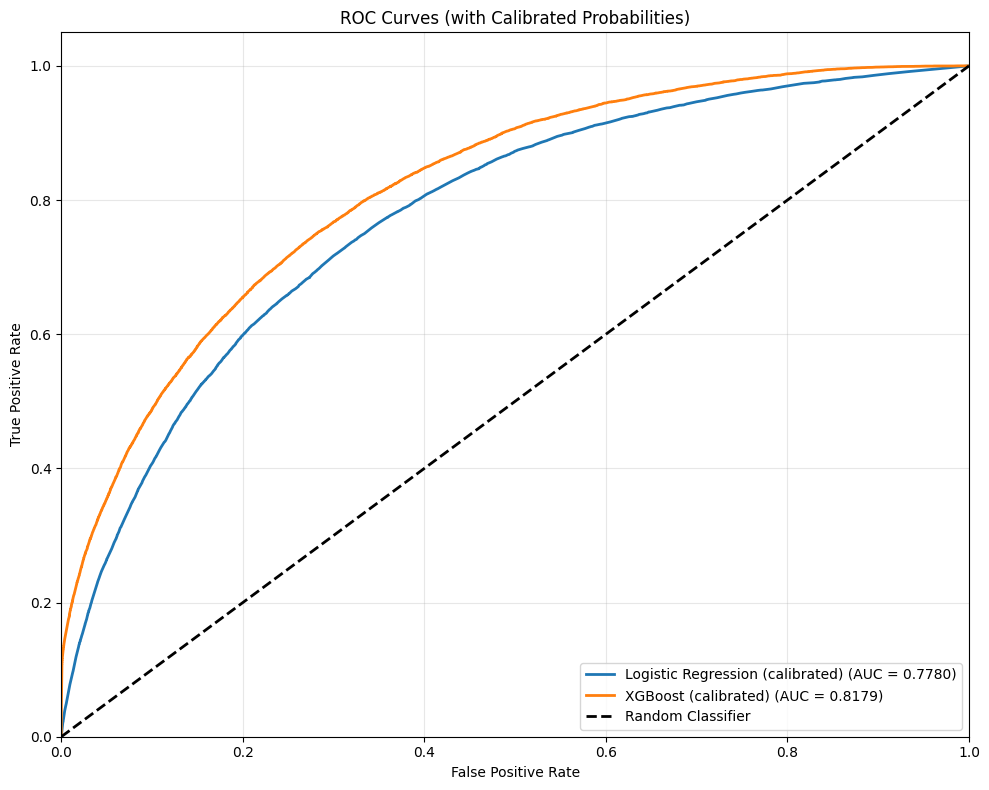

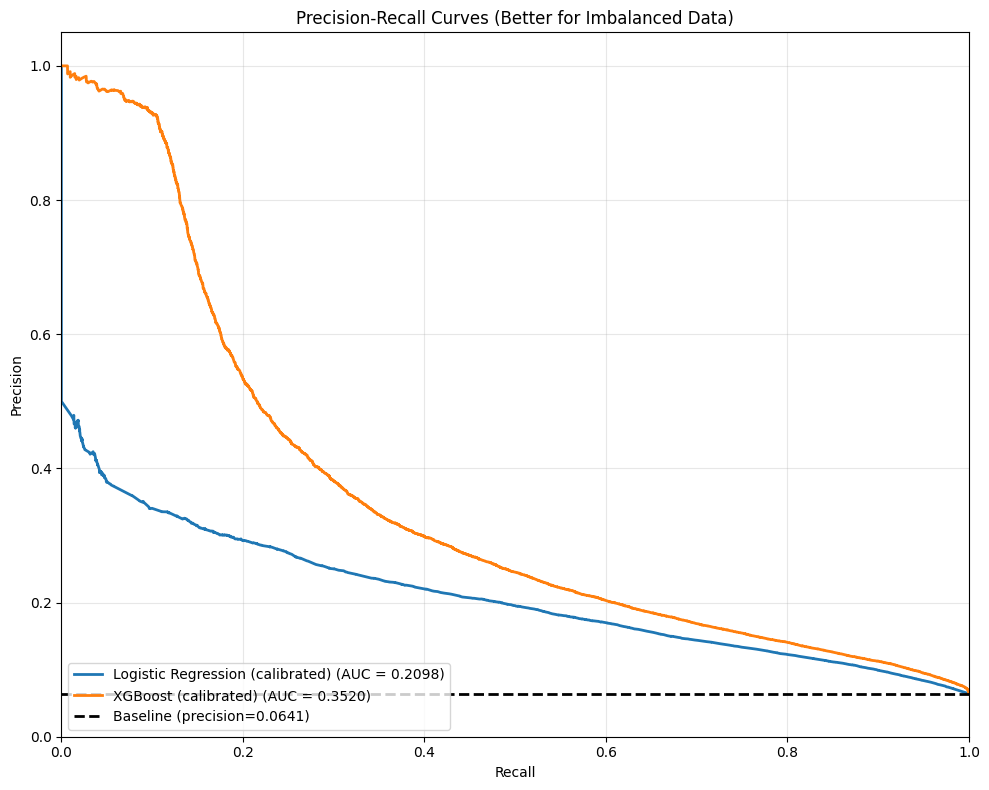

In [27]:
# ROC Curves
plt.figure(figsize=(10, 8))
for model_name in models.keys():
    # Use calibrated probabilities if available
    if model_name in calibrated_proba_test:
        y_proba = calibrated_proba_test[model_name]
        label_suffix = " (calibrated)"
    elif model_name in test_proba:
        y_proba = test_proba[model_name][:, 1]
        label_suffix = ""
    else:
        continue
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name}{label_suffix} (AUC = {roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (with Calibrated Probabilities)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Precision-Recall Curves (better for imbalanced data)
plt.figure(figsize=(10, 8))
for model_name in models.keys():
    # Use calibrated probabilities if available
    if model_name in calibrated_proba_test:
        y_proba = calibrated_proba_test[model_name]
        label_suffix = " (calibrated)"
    elif model_name in test_proba:
        y_proba = test_proba[model_name][:, 1]
        label_suffix = ""
    else:
        continue
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name}{label_suffix} (AUC = {pr_auc:.4f})', linewidth=2)

# Baseline: predict all as positive class
baseline_precision = y_test.mean()
plt.axhline(y=baseline_precision, color='k', linestyle='--', linewidth=2, 
            label=f'Baseline (precision={baseline_precision:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Better for Imbalanced Data)')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



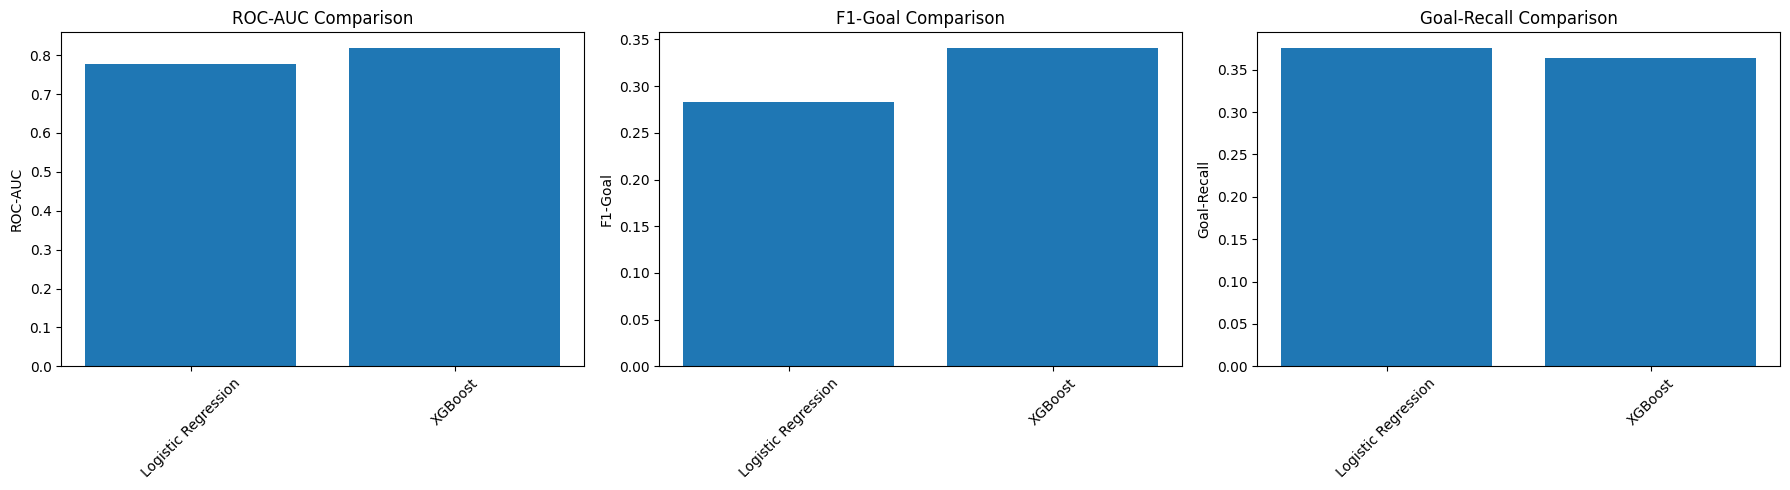


Best model by ROC-AUC: XGBoost
  ROC-AUC: 0.8179
  Goal Recall: 0.3638
  Goal F1: 0.3406


In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['ROC-AUC', 'F1-Goal', 'Goal-Recall']
for idx, metric in enumerate(metrics):
    axes[idx].bar(results_df['Model'], results_df[metric])
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Select best model by ROC-AUC (primary metric for imbalanced data)
best_model_name = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']
print(f"\nBest model by ROC-AUC: {best_model_name}")
print(f"  ROC-AUC: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'ROC-AUC']:.4f}")
print(f"  Goal Recall: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'Goal-Recall']:.4f}")
print(f"  Goal F1: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'F1-Goal']:.4f}")


In [29]:
best_model = models[best_model_name]

if hasattr(best_model, 'coef_'):
    l2_penalty = np.sum(best_model.coef_**2)
    print(f"L2 penalty (sum of squared coefficients): {l2_penalty:.4f}")

ridge_model = Ridge(alpha=0.5, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
ridge_pred_binary = (ridge_pred > 0.5).astype(int)
ridge_mse = np.mean((y_test - ridge_pred)**2)
print(f"Ridge Regression MSE: {ridge_mse:.4f}")


Ridge Regression MSE: 0.0561


Calibration Comparison for XGBoost:
  Original Brier Score: 0.1688
  Calibrated Brier Score: 0.0498
  Improvement: 0.1190


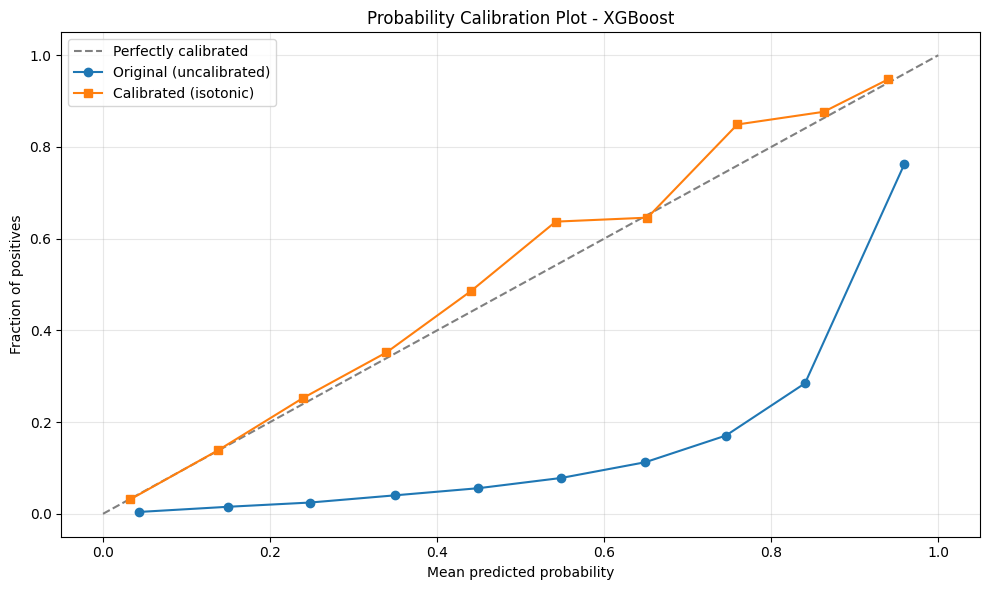

In [30]:
# Calibration comparison (using already-calibrated models from Cell 16)
if best_model_name in test_proba:
    original_proba = test_proba[best_model_name][:, 1]
    
    if best_model_name in calibrated_proba_test:
        calibrated_proba_pos = calibrated_proba_test[best_model_name]
        
        print(f"Calibration Comparison for {best_model_name}:")
        print(f"  Original Brier Score: {brier_score_loss(y_test, original_proba):.4f}")
        print(f"  Calibrated Brier Score: {brier_score_loss(y_test, calibrated_proba_pos):.4f}")
        print(f"  Improvement: {brier_score_loss(y_test, original_proba) - brier_score_loss(y_test, calibrated_proba_pos):.4f}")
        
        from sklearn.calibration import calibration_curve
        
        prob_true_orig, prob_pred_orig = calibration_curve(y_test, original_proba, n_bins=10)
        prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_proba_pos, n_bins=10)
        
        plt.figure(figsize=(10, 6))
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
        plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='Original (uncalibrated)')
        plt.plot(prob_pred_cal, prob_true_cal, marker='s', label='Calibrated (isotonic)')
        plt.xlabel('Mean predicted probability')
        plt.ylabel('Fraction of positives')
        plt.title(f'Probability Calibration Plot - {best_model_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Note: {best_model_name} probabilities were not calibrated in Cell 16")


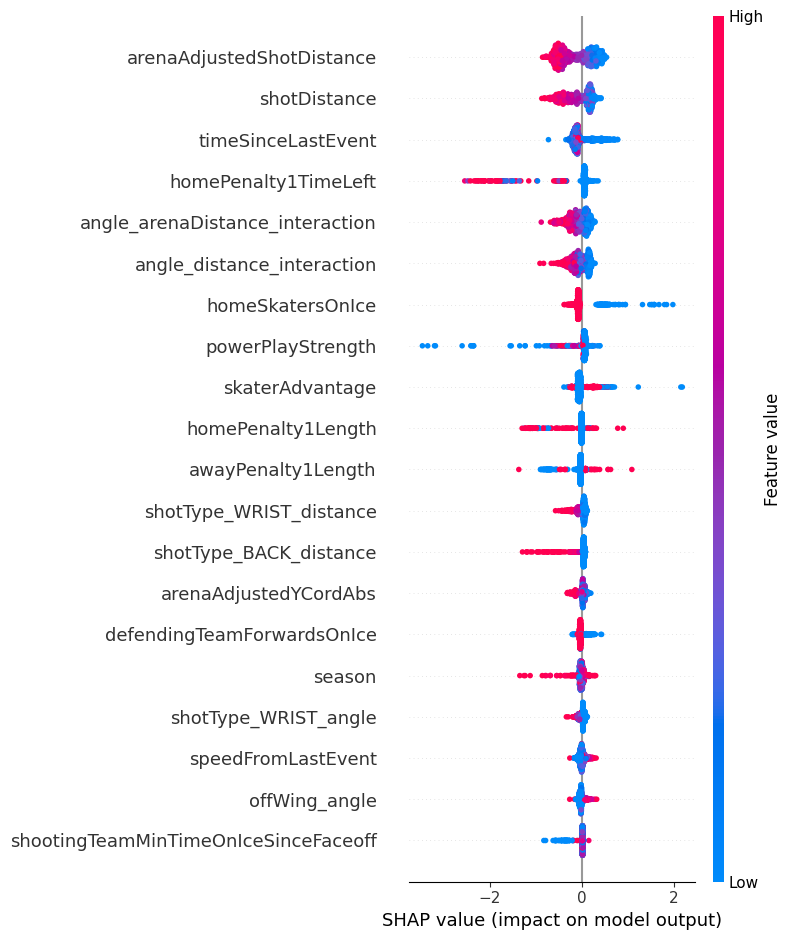


Top 10 features by SHAP importance:
                             Feature  SHAP Importance
81         arenaAdjustedShotDistance         0.348445
12                      shotDistance         0.258139
2                 timeSinceLastEvent         0.176240
29              homePenalty1TimeLeft         0.172361
99   angle_arenaDistance_interaction         0.165629
98        angle_distance_interaction         0.149280
25                  homeSkatersOnIce         0.147758
125                powerPlayStrength         0.114883
120                  skaterAdvantage         0.105563
30                homePenalty1Length         0.083692


In [31]:
if best_model_name == 'XGBoost':
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_scaled[:1000])
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    shap.summary_plot(shap_values, X_test_scaled[:1000], feature_names=X_train.columns.tolist(), 
                     max_display=20, show=False)
    plt.tight_layout()
    plt.show()
    
    shap_values_mean = np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame({
        'Feature': X_train.columns.tolist(),
        'SHAP Importance': shap_values_mean
    }).sort_values('SHAP Importance', ascending=False)
    
    print("\nTop 10 features by SHAP importance:")
    print(feature_importance_shap.head(10))
else:
    print("SHAP analysis skipped (best model is not tree-based)")


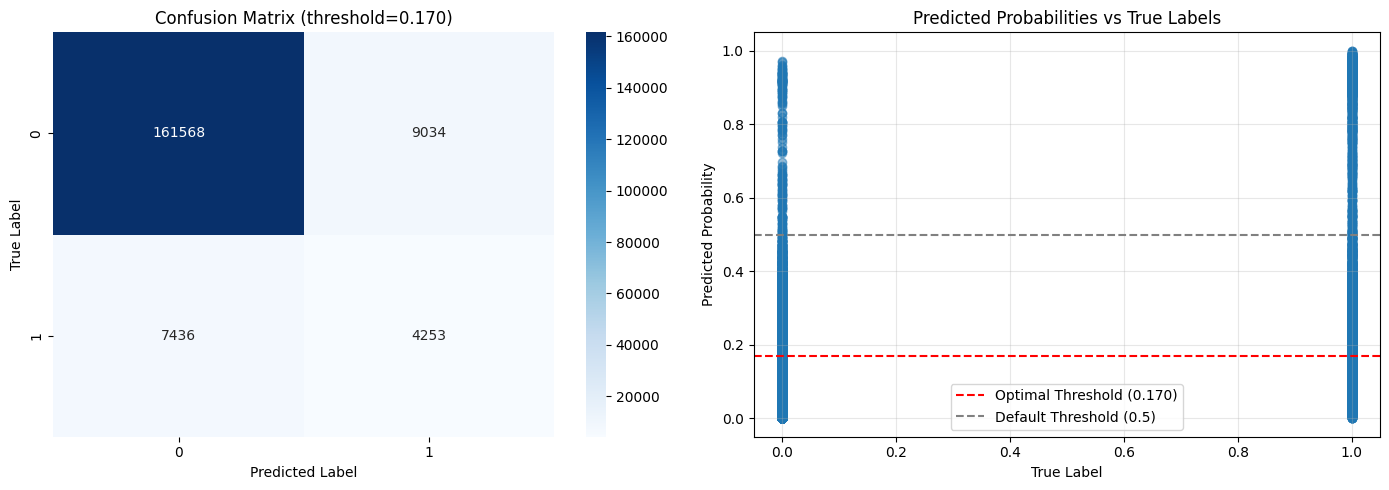


XGBoost - Threshold: 0.170 (calibrated probabilities):
  True Negatives:  161568
  False Positives:   9034 (5.3% false alarm rate)
  False Negatives:   7436 (63.6% missed goals)
  True Positives:    4253
  ROC-AUC: 0.8179
  Goal Recall: 0.3638 (36.4% of goals caught)
  Goal Precision: 0.3201 (32.0% of goal predictions correct)
  Goal F1: 0.3406
  Accuracy: 0.9096
  F1-Score (weighted): 0.9123
  Brier Score: 0.0498
  Log Loss: 0.1872


In [32]:
if best_model_name in test_proba:
    y_pred_best = test_predictions_optimal[best_model_name]
    # Use calibrated probabilities if available
    if best_model_name in calibrated_proba_test:
        y_proba_best = calibrated_proba_test[best_model_name]
        proba_label = "calibrated"
    else:
        y_proba_best = test_proba[best_model_name][:, 1]
        proba_label = "original"
    opt_threshold = optimal_thresholds.get(best_model_name, 0.5)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix (threshold={opt_threshold:.3f})')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    axes[1].scatter(y_test, y_proba_best, alpha=0.5)
    axes[1].axhline(y=opt_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({opt_threshold:.3f})')
    axes[1].axhline(y=0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
    axes[1].set_xlabel('True Label')
    axes[1].set_ylabel('Predicted Probability')
    axes[1].set_title('Predicted Probabilities vs True Labels')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred_best, labels=[0, 1], zero_division=0
    )
    
    # Confusion matrix details
    cm = confusion_matrix(y_test, y_pred_best)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{best_model_name} - Threshold: {opt_threshold:.3f} ({proba_label} probabilities):")
    print(f"  True Negatives:  {tn:6d}")
    print(f"  False Positives: {fp:6d} ({fp/(fp+tn)*100:.1f}% false alarm rate)")
    print(f"  False Negatives: {fn:6d} ({fn/(fn+tp)*100:.1f}% missed goals)")
    print(f"  True Positives:  {tp:6d}")
    print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba_best):.4f}")
    print(f"  Goal Recall: {recall[1]:.4f} ({recall[1]*100:.1f}% of goals caught)")
    print(f"  Goal Precision: {precision[1]:.4f} ({precision[1]*100:.1f}% of goal predictions correct)")
    print(f"  Goal F1: {f1[1]:.4f}")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"  F1-Score (weighted): {f1_score(y_test, y_pred_best, average='weighted'):.4f}")
    print(f"  Brier Score: {brier_score_loss(y_test, y_proba_best):.4f}")
    if best_model_name in calibrated_proba_test:
        print(f"  Log Loss: {log_loss(y_test, calibrated_models[best_model_name].predict_proba(X_test_scaled)):.4f}")
    else:
        print(f"  Log Loss: {log_loss(y_test, test_proba[best_model_name]):.4f}")


In [33]:
best_row = results_df[results_df['Model'] == best_model_name].iloc[0]
print(f"\nBest model: {best_model_name}")
print(f"  ROC-AUC: {best_row['ROC-AUC']:.4f}")
print(f"  Goal Recall: {best_row['Goal-Recall']:.4f} ({best_row['Goal-Recall']*100:.1f}% of goals caught)")
print(f"  Goal F1: {best_row['F1-Goal']:.4f}")
print(f"  Goal Precision: {best_row['Goal-Precision']:.4f}")
print(f"  Optimal Threshold: {best_row['Threshold']:.3f}")
print(f"  Accuracy: {best_row['Accuracy']:.4f}")
print(f"  F1-Score (weighted): {best_row['F1-Weighted']:.4f}")
print(f"  Brier Score: {best_row['Brier Score']:.4f}")
print(f"Total models evaluated: {len(models)}")
print(f"Training time range: {min(training_times.values()):.2f} - {max(training_times.values()):.2f} ms")



Best model: XGBoost
  ROC-AUC: 0.8179
  Goal Recall: 0.3638 (36.4% of goals caught)
  Goal F1: 0.3406
  Goal Precision: 0.3201
  Optimal Threshold: 0.170
  Accuracy: 0.9096
  F1-Score (weighted): 0.9123
  Brier Score: 0.0498
Total models evaluated: 2
Training time range: 10890.21 - 26830.38 ms
